**Reference**: <https://adv-r.hadley.nz/function-factories.html>

In [18]:
library(rlang)
library(tidyverse)
library(scales)

# What is Function Factories

A function factory is a function that return another function, the returned funcion is called manufactured function. A function factory is a function that makes function.

In [2]:
power <- function(exp) {
    function(x)
        x ^ exp
}

power_to_2 <- power(2)
power_to_3 <- power(3)


power_to_2(5)

[1] 25

# The Problem with Lazy evaluation

In [3]:
n <- 2
power_to_2 <- power(n)
n <- 3

power_to_2(5) # expect equal to 5 ^ 2, but turns out it is 5 ^ 3

[1] 125

when we call `power_to_2 <- power(n)`, `exp` is lazy evaluated to the value `n`. It means that when it get evaluated, it will be equal to the value of `n` at the time it is evaluated. But in the function call of `power`, `exp` never get evaluated, so currently, `exp` does not equal to 2, even though currently, `n = 2` . Now we change `n <- 3`. Then when we call `power_to_2(5)`, which executes `x^exp`, now `exp` is evaluated, so `exp` will evaluate to the value of `n` at the evaluation time, which is 3, so the result is `5^3`

Solve this with **`force()`**

In [9]:
power <- function(exp) {
    # this time, whenever a manfactured is created 
    # if we pass a variable to the argument
    # it will be evaluated immediately
    force(exp)
    function(x)
        x ^ exp
}
n <- 2
power_to_2 <- power(n)
# pass `n` to function `power`, so `exp` will lazily evaluate to the value of `n`
# but inside the function call of `power`
# we force `exp` to evaluate, not lazy, so `exp` will be assigned to the current value of `n` is 2
n <- 3
# change the value of `n` will not matter now becaused `exp` had been evaluated

power_to_2(5)

[1] 25

> Exercise: Create a function `pick()` that takes an index, `i`, as an argument and returns a function with an argument `x` that subsets `x` with `i`.

In [10]:
pick <- function(i) {
  # remember to force evaluation here
  force(i)
  function(x)
    x[[i]]
}

# a function that extracts the fifth element from a vector
fifth <- pick(5)

fifth(3:10)

[1] 7

In [13]:
n <- 5
fifth <- pick(n)
n <- 6
# this will still return 5, because we forced evaluation inside `pick`
fifth(1:10)

[1] 5

# Stateful function

Make a function that returns the number of times it is called

In [14]:
make_counter <- function() {
    cnt <- 0
    function() {
        # <<- helps refer to `cnt` of the enclosing environment of this function
        cnt <<- cnt + 1
        cnt
    }
}

counter <- make_counter()

for(i in 1:5) {
    print(counter())
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


what happens if we change `<<-` to `<-`?

In [15]:
make_counter <- function() {
    cnt <- 5
    function() {
        # cnt on the left side belongs to the execution environment of this function
        # cnt on the right side belongs to the enclosing enviroment of this function (which is 5)
        
        cnt <- cnt + 1
        cnt
    }
}

counter <- make_counter()
print(counter())
print(counter())
print(counter())

[1] 6
[1] 6
[1] 6


# Application to Graphical factories

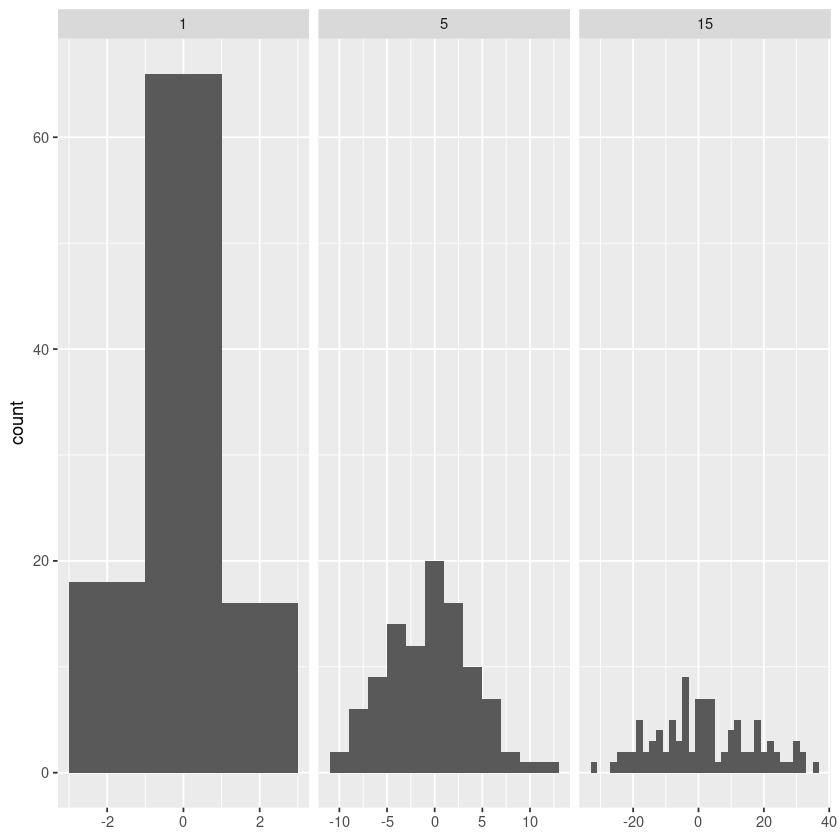

In [19]:
# construct some sample data with very different numbers in each cell
sd <- c(1, 5, 15)
n <- 100

df <- data.frame(x = rnorm(3 * n, sd = sd), sd = rep(sd, n))

ggplot(df, aes(x)) + 
  geom_histogram(binwidth = 2) + 
  facet_wrap(~ sd, scales = "free_x") + 
  labs(x = NULL)

Fixed `bithwidth` is not useful, turn `binwidth` to a function

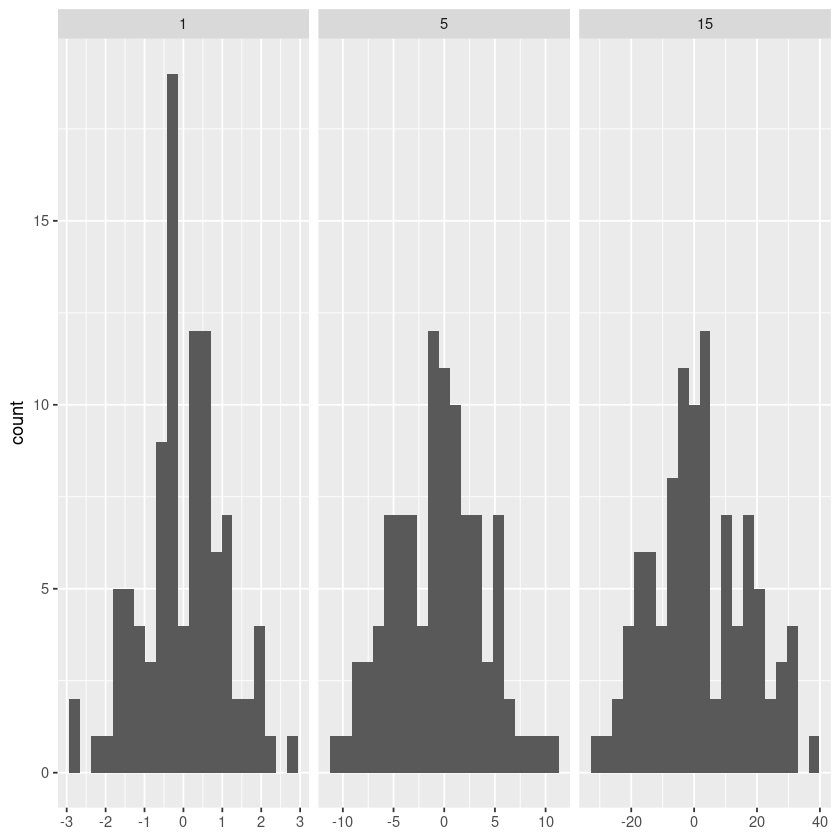

In [22]:
binwidth_bins <- function(n) {
    force(n)
    function(x) {
        (max(x) - min(x)) / n
    }
}

# using 20 bins
# we cound have used `bins = 20`
# but we use a function to the `binwidth` argument to ilustrate the idea of function factory
ggplot(df, aes(x)) + 
  geom_histogram(binwidth = binwidth_bins(20)) + 
  facet_wrap(~ sd, scales = "free_x") + 
  labs(x = NULL)

# Function Factories + Functionals

Turn data into function, let's say you have a named list of functions:

In [23]:
power <- function(exp) {
    force(exp)
    function(x) 
        x ^ exp
}

function_names <- list(
  square = 2, 
  cube = 3, 
  root = 1/2, 
  cuberoot = 1/3, 
  reciprocal = -1
)

funcs <- function_names %>% map(power)
# a named list of functions
funcs

$square
function(x) 
        x ^ exp
<environment: 0x55d0d4b2e0e0>

$cube
function(x) 
        x ^ exp
<bytecode: 0x55d0d41ac0e8>
<environment: 0x55d0d4b2e428>

$root
function(x) 
        x ^ exp
<bytecode: 0x55d0d41ac0e8>
<environment: 0x55d0d41a8698>

$cuberoot
function(x) 
        x ^ exp
<bytecode: 0x55d0d41ac0e8>
<environment: 0x55d0d41a89a8>

$reciprocal
function(x) 
        x ^ exp
<bytecode: 0x55d0d41ac0e8>
<environment: 0x55d0d41a4e50>

If you want to use a function, you have to prefix the call with `funcs$`

In [24]:
funcs$square(5)
funcs$root(25)

[1] 25

[1] 5

for a temporary effect, you can use `with`:

In [27]:
with(funcs, square(10))
with(funcs, root(5))

[1] 100

[1] 2.236068

<b style = 'color:red'>NOTE:</b> I recommend this because it makes it very clear when code is being executed in a special context and what that context is.

For a longer effect, you can `attach()` the functions to the search path, then `detach()` when you’re done:

In [43]:
# attach `funcs` to the search path
# so functions inside `funcs` will be available in the search path
#  Therefore, the provided functions are found before their respective versions from the {base} package.
# . Further, they cannot get accidently overwritten by similar named functions in the global environment
attach(funcs)
# search path
search()

The following objects are masked _by_ .GlobalEnv:

    cube, cuberoot, reciprocal, root, square




[1] ".GlobalEnv"        "funcs"             "package:scales"   
 [4] "package:forcats"   "package:stringr"   "package:dplyr"    
 [7] "package:purrr"     "package:readr"     "package:tidyr"    
[10] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[13] "package:rlang"     "jupyter:irkernel"  "package:stats"    
[16] "package:graphics"  "package:grDevices" "package:utils"    
[19] "package:datasets"  "package:methods"   "Autoloads"        
[22] "package:base"

Functions inside `func` are now included in the search path, so we can use without prefix `funcs$`

In [33]:
square(5)
cube(10)

[1] 25

[1] 1000

One annoying downside of using `attach()` is the possibility to attach the same object multiple times, making it necessary to call `detach()` equally often

In [44]:
attach(funcs)
# detach this list of functions from the search path
detach(funcs)
detach(funcs)

search()

The following objects are masked _by_ .GlobalEnv:

    cube, cuberoot, reciprocal, root, square


The following objects are masked from funcs (pos = 3):

    cube, cuberoot, reciprocal, root, square




[1] ".GlobalEnv"        "package:scales"    "package:forcats"  
 [4] "package:stringr"   "package:dplyr"     "package:purrr"    
 [7] "package:readr"     "package:tidyr"     "package:tibble"   
[10] "package:ggplot2"   "package:tidyverse" "package:rlang"    
[13] "jupyter:irkernel"  "package:stats"     "package:graphics" 
[16] "package:grDevices" "package:utils"     "package:datasets" 
[19] "package:methods"   "Autoloads"         "package:base"

- Finally, you could copy the functions to the global environment with `rlang::env_bind`.  This just adds the functions in fun to the global environment. No further side effects are introduced, and the functions are overwritten when similarly named functions are defined. 

In [45]:
rlang::env_bind(globalenv(), !!!funcs)

In [46]:
# in the global environment
ls.str(globalenv()) %>% tail()

[1] "power_to_2" "power_to_3" "reciprocal" "root"       "sd"        
[6] "square"

>Compare and contrast the effects of `env_bind()` vs. `attach()` for the following code.
>```r
funs <- list(
  mean = function(x) mean(x, na.rm = TRUE),
  sum = function(x) sum(x, na.rm = TRUE)
)
attach(funs)
#> The following objects are masked from package:base:
#> 
#>     mean, sum
mean <- function(x) stop("Hi!")
detach(funs)
env_bind(globalenv(), !!!funs)
mean <- function(x) stop("Hi!") 
env_unbind(globalenv(), names(funs))
```

See the solution here: <https://advanced-r-solutions.rbind.io/function-factories.html#function-factories-functionalshttps://advanced-r-solutions.rbind.io/function-factories.html#function-factories-functionals>